In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

from tqdm.keras import TqdmCallback
import os

In [4]:
"""Выборка для обучения получена из работы
Arrhenius Crossover Temperature of Glass-Forming Liquids Predicted by an Artificial Neural Network """
# Подготовленные данные в виде Excel таблицы, в случае отсутсвия можете получить по ссылке
# https://disk.yandex.ru/i/JURRL-BjFInPUg
# Дополнительная информация:
# В таблице 91 запись, из них 57 - с известными экспериментальными T_A_empirical, остальные без (NaN)
# Обязательные столбцы при составлении выборки: ['T_g','T_m','T_A_empirical','m']
try:
    excel_import = pd.read_excel('..\\data\\input_data.xlsx')
except FileNotFoundError:
    print(f'В папку с NoteBook\'ом добавьте файл input_data.xlsx.\n'
          f'Скачать можно по ссылке https://disk.yandex.ru/i/JURRL-BjFInPUg')
    raise FileNotFoundError
excel_import.loc[:, 'T_g/T_m'] = excel_import.loc[:, 'T_g'] / excel_import.loc[:, 'T_m']

In [5]:
excel_import

,No,System,T_g,T_m,m,T_A_predicted,T_A_empirical,T_g/T_m
0,1,SiO_{2},1450,2000,17.9,2007,NaN,0.725000
1,2,Li_{2} O·SiO_{2},593,1573,33.9,1633,NaN,0.376987
2,3,Li_{2} O·2SiO_{2},727,1306,34.7,1495,NaN,0.556662
3,4,Li_{2} O·3SiO_{2},734,1306,26.3,1508,NaN,0.562021
4,5,Na_{2} O·SiO_{2},687,1362,40.3,1523,NaN,0.504405
...,...,...,...,...,...,...,...,...
86,87,Pd_{40} Ni_{40} P_{20},560,1030,50.0,1019,1157.0,0.543689
87,88,Pd_{82} Si_{18},648,1071,106.0,1177,1186.0,0.605042
88,89,Ni_{34} Zr_{66},760,1283,24.0,1525,1506.0,0.592362
89,90,Ni_{59.5} Nb_{40.5},930,1448,136.0,1618,1658.0,0.642265


Text(0, 0.5, '$T_predicted, K$')

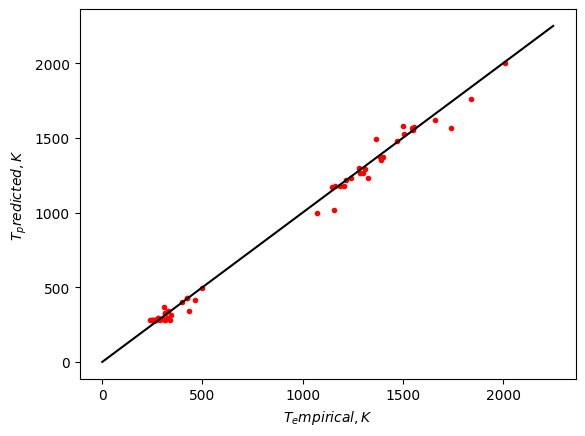

In [4]:
## Анализ уже имеющихся данных
plt.plot(excel_import.loc[:, 'T_A_empirical'], excel_import.loc[:, 'T_A_predicted'], '.r')
plt.plot([0, 2250], [0, 2250], '-k')
plt.xlabel('$T_empirical, K$')
plt.ylabel('$T_predicted, K$')

In [5]:
# Максимальный вылет температур в работе - 170К. :
excel_import['difference'] = (excel_import.loc[:, 'T_A_empirical'] - excel_import.loc[:, 'T_A_predicted']).abs()
id_max = excel_import['difference'].idxmax()

print(f"Максимальное отклонение в {excel_import.loc[id_max, 'difference']}К для {excel_import.loc[id_max, 'System']}")

Максимальное отклонение в 170.0К для Zr_{57} Ni_{43}


In [14]:
# Оптимизация ввода данных
# Массив данных на ввод нейронке
input_plan = [['m'],
              ['T_g/T_m'],
              ['T_g/T_m', 'm'],
              ['T_g', 'm'],
              ['T_g'],
              ['T_g', 'T_m'],
              ['T_g', 'T_m', 'm'],
              ['T_m'],
              ['T_g', 'T_m', 'T_g/T_m', 'm']]

In [8]:
# Конфигурация нейронки
BATCH_SIZE = 128  # размер пакета 128>57, SGD переходит в обычный градиентный спуск
TRAIN_RATE = 0.3
EPOCHS = 5000

In [7]:
train_data = excel_import[excel_import.T_A_empirical.notna()].loc[:,
             ['T_g', 'T_m', 'T_g/T_m', 'm', 'T_A_empirical']]
## Данные, которые с известным экспериментальным значением, поделим на 10000, чтобы значения были в [0,1]
train_data

,T_g,T_m,T_g/T_m,m,T_A_empirical
34,995,1664,0.597957,59.0,1839.0
35,1087,1393,0.780330,24.0,1503.0
36,1113,1825,0.609863,54.0,2010.0
37,530,723,0.733057,36.0,1073.0
38,208,321,0.647975,125.0,328.0
39,179,238,0.752101,75.0,241.0
40,185,270,0.685185,70.0,262.0
41,195,275,0.709091,70.0,261.0
42,187,223,0.838565,60.0,251.0
43,196,234,0.837607,66.0,268.0


In [9]:
target_normalizer = tf.keras.layers.Normalization(axis=1)
target_normalizer.adapt(train_data['T_A_empirical'])

target_denormalizer = tf.keras.layers.Normalization(axis=1, invert=True)
target_denormalizer.adapt(train_data['T_A_empirical'])


In [10]:
# Модель
def get_model(input_plan):
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(len(input_plan),)),
        tf.keras.layers.Dense(10, activation='tanh'),
        tf.keras.layers.Dense(10, activation='tanh'),
        tf.keras.layers.Dense(1),
    ])
    optimizer = tf.keras.optimizers.SGD(learning_rate=TRAIN_RATE)
    model.compile(optimizer=optimizer,
                  loss='mse')
    return model

In [11]:
train_data

,T_g,T_m,T_g/T_m,m,T_A_empirical
34,995,1664,0.597957,59.0,1839.0
35,1087,1393,0.780330,24.0,1503.0
36,1113,1825,0.609863,54.0,2010.0
37,530,723,0.733057,36.0,1073.0
38,208,321,0.647975,125.0,328.0
39,179,238,0.752101,75.0,241.0
40,185,270,0.685185,70.0,262.0
41,195,275,0.709091,70.0,261.0
42,187,223,0.838565,60.0,251.0
43,196,234,0.837607,66.0,268.0


In [12]:
train_target = tf.transpose(target_normalizer(train_data['T_A_empirical']))
to_do =
if to_do:
    for i, plan in enumerate(input_plan):
        input_normalizer = tf.keras.layers.Normalization()
        input_normalizer.adapt(train_data.loc[:, plan])

        train_input = input_normalizer(train_data[plan])
        model = get_model(plan)
        model.fit(train_input, train_target,
                  verbose=0,  # отключение вывода tf
                  callbacks=[TqdmCallback(verbose=0)],
                  batch_size=BATCH_SIZE,
                  epochs=EPOCHS)  # вывод с помощью TQDM
        model.save(f'models\\series_input\\model_{i}')

In [20]:
# подсчет MSE для каждой модели на всей выборке
model_folders = os.listdir('models\\series_input')

for i, folder in enumerate(model_folders):
    input_normalizer = tf.keras.layers.Normalization()
    input_normalizer.adapt(train_data[input_plan[i]])
    train_input = input_normalizer(train_data[input_plan[i]])

    model = tf.keras.models.load_model(f'models\\series_input\\{folder}')
    predict = target_denormalizer(model.predict(train_input))
    table = pd.DataFrame(train_data['T_A_empirical'])
    table['T_A_predicted'] = predict
    table['difference'] = (table['T_A_empirical'] - table['T_A_predicted']).abs()

    table.to_csv(f'..\\data\\input_series_data\\model_{i}_data.csv')

2/2 [==============================] - 0s 2ms/step


In [17]:
data_folders = os.listdir('..\\data\\input_series_data')
data_folders

['model_0_data.csv',
 'model_1_data.csv',
 'model_2_data.csv',
 'model_3_data.csv',
 'model_4_data.csv',
 'model_5_data.csv',
 'model_6_data.csv',
 'model_7_data.csv',
 'model_8_data.csv']

In [19]:
%matplotlib tk


fig, axs = plt.subplots(figsize=(9,7),nrows=3, ncols=3)
fig.suptitle('Температуры Аррениуса для разных входных данных')
mse_table = np.array([])
max_difference = np.array([])
for i, data in enumerate(data_folders):
    table = pd.read_csv(f'..\\data\\input_series_data\\{data}')
    mse = (table['difference'].sum() / table['difference'].shape[0]) ** (1 / 2)
    mse_table = np.append(mse_table, mse)
    max_difference = np.append(max_difference, table['difference'].max())
    j = i % 3
    k = int(i / 3)
    axs[j, k].plot(table['T_A_predicted'], table['T_A_empirical'], '.r')
    axs[j, k].plot([0, 2250], [0, 2250], '-k')
    axs[j, k].set_ylabel('$T_{emp}, K$')
    axs[j, k].set_xlabel('$T_{pred}, K$')
    axs[j,k].text(1000,0,f'mse = {np.round(mse,2)}\nmax_diff = {np.round(max_difference[i],2)}')
    str_plan = ', '.join(input_plan[i])
    axs[j, k].set_title(f'${str_plan}$')

print(mse_table)
print(max_difference)
fig.tight_layout()
fig.show()
fig.savefig('..\\graphics\\Temp_from_input')



[13.99890578 15.5835851   6.91676773  6.86047066  7.91156033  5.50271948
  4.77072124  6.80275578  4.48253068]
[1259.9911499   953.00939941  156.29315186  251.24865723  307.83740234
  108.06872559  121.30444336  232.96221924   93.2878418 ]


In [102]:
data_table = pd.DataFrame([])
data_table['Input Format'] = input_plan
data_table['MSE'] = mse_table
data_table['Max Difference'] =max_difference
data_table.to_csv('..\\data\\input_series_statistics.csv')

In [163]:
data_table

,Input Format,MSE,Max Difference
0,[m],13.998906,1259.991150
1,[T_g/T_m],15.583585,953.009399
2,"[T_g/T_m, m]",6.916768,156.293152
3,"[T_g, m]",6.860471,251.248657
4,[T_g],7.911560,307.837402
5,"[T_g, T_m]",5.502719,108.068726
6,"[T_g, T_m, m]",4.770721,121.304443
7,[T_m],6.802756,232.962219
8,"[T_g, T_m, T_g/T_m, m]",4.482531,93.287842


In [188]:
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"))

ax.pie(data_table['MSE'],
       labels=np.round(data_table['MSE'],2),
       rotatelabels=False,
       radius=1,
       labeldistance=.6,
       textprops={'fontsize':12})
labels = ['$'+' ,'.join(plan)+'$' for plan in input_plan]
ax.legend(labels,
          title="Input",
          loc="center left",
          bbox_to_anchor=(1, 0, 0, 1))

ax.set_title("MSE для разных вводных данных",fontdict={'fontsize':24,'font':'Times New Roman'})
fig.savefig('..\\graphics\\MSE_Pie_from_input')
fig.show()

In [ ]:
## Проверка